In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [12]:
df_patients = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=0)
df_admissions = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=1)
df_icu_stays = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=2)
df_bypass_surgeries = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=3)
df_haemoglobins = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=4)
df_transfusions = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=5)

In [13]:
# change metrics from g/l into g/dl
df_haemoglobins['REFERENCE_LOW'] = df_haemoglobins['REFERENCE_LOW']/10
df_haemoglobins['REFERENCE_HIGH'] = df_haemoglobins['REFERENCE_HIGH']/10
df_haemoglobins['RESULT'] = df_haemoglobins['RESULT']/10

In [14]:
df_transfusions = df_transfusions.dropna()

print(df_admissions["PATIENT_NUMBER"].nunique(),df_admissions["ADMISSION_NUMBER"].nunique())
print(len(df_bypass_surgeries["SURGERY_NUMBER"]),df_admissions["PATIENT_NUMBER"].nunique())

265 265
268 265


In [15]:
df_transfusions = pd.merge(df_transfusions,df_patients[["PATIENT_NUMBER","Gender"]], on=["PATIENT_NUMBER"],how = "inner")

In [16]:
# the increase to additiona rows is caused by patient having multiple surgeries but it's ok
df_transfusions_merged= pd.merge(df_transfusions,df_bypass_surgeries[["PATIENT_NUMBER","ADMISSION_NUMBER","FINISH_TIME"]], on=["PATIENT_NUMBER","ADMISSION_NUMBER"],how = "inner")

In [17]:
## eliminate transfusion that's been done before the CABGsurgery is commenced
df_transfusions_merged = df_transfusions_merged.loc[df_transfusions_merged["BLOOD_START_TIME"] > df_transfusions_merged["FINISH_TIME"]]
## the update list shows that there are 67 patients that has underwent blood transfusion after surgery
df_transfusions_merged["PATIENT_NUMBER"].nunique()

65

In [18]:
## Q1, keep the earliest blood transfusion time for each patient, and search for the most recent hb test
first_transfusion = df_transfusions_merged.groupby(["PATIENT_NUMBER"])[["BLOOD_START_TIME","VOLUME","Gender"]].agg("min")
first_transfusion = pd.DataFrame(first_transfusion)


In [19]:
first_transfusion

,BLOOD_START_TIME,VOLUME,Gender
PATIENT_NUMBER,,,
6,2021-09-25 10:06:00,258.00,F
16,2022-04-10 17:59:00,271.97,M
17,2021-12-14 19:02:00,255.00,M
18,2022-04-05 17:50:00,250.00,M
23,2021-06-02 10:17:00,244.00,M
...,...,...,...
253,2021-09-01 10:20:00,261.00,M
255,2022-03-30 01:25:00,332.00,M
258,2021-11-29 12:26:00,247.00,M


In [20]:
# the product of 2 timedate transforms the data into timedelta
## the hb value is the patient most recent hb value before the first blood transfusion
hb_value = []
for row_index, row in first_transfusion.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row_index] 
    ## find hb test that happened before the first blood transfusion
    temp_df = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() > 0]
    
    ## pick the most recent or the largest time 
    hb_value.append(float(temp_df.loc[temp_df["RESULT_TIME"] == temp_df["RESULT_TIME"].max()]["RESULT"]))

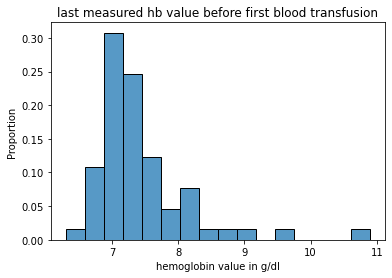

In [56]:
## plot for Q1
sns.histplot(hb_value,stat="probability") 
plt.title('Last measured hb value before first blood transfusion')
plt.xlabel("hemoglobin value in g/dl")
plt.ylabel('Proportion')
plt.show()

In [22]:
## mean/std for the hb value of q1

print(np.mean(hb_value),np.std(hb_value))

7.424615384615384 0.7270659200313311


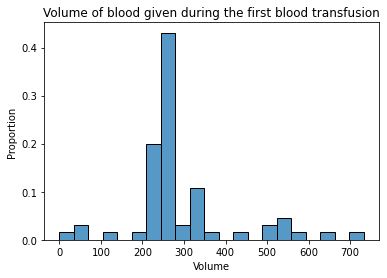

In [57]:
##q2
sns.histplot(first_transfusion["VOLUME"],stat="probability")
plt.title('Volume of blood given during the first blood transfusion')
plt.xlabel("Volume")
plt.ylabel('Proportion')
plt.show()

In [59]:
## mean/std of total_volume
np.mean(first_transfusion["VOLUME"])

291.03061538461543

<AxesSubplot:xlabel='VOLUME', ylabel='Probability'>

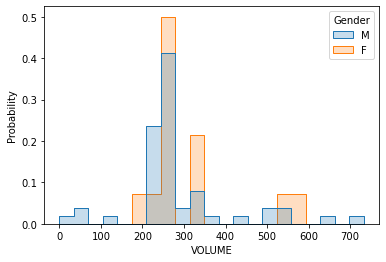

In [60]:
##q2 with gender
sns.histplot(first_transfusion,x = "VOLUME",stat="probability",hue = "Gender",element="step",common_norm=False)
plt.title('Volume of blood given during the first blood transfusion by gender')
plt.xlabel("Volume")
plt.ylabel('Proportion')
plt.show()

In [61]:

print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "M"]["VOLUME"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "M"]["VOLUME"]))
print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "F"]["VOLUME"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "F"]["VOLUME"]))

287.01705882352945
130.2972243590139
305.65142857142854
104.16065996177956


In [29]:
difference = []
pretrans_value = []
for row_index, row in df_transfusions_merged.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row["PATIENT_NUMBER"]] 
    temp_df_pretrans = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() > 0]
    
    pretrans = float(temp_df_pretrans.loc[temp_df_pretrans["RESULT_TIME"] == temp_df_pretrans["RESULT_TIME"].max()]["RESULT"])
    pretrans_value.append(pretrans) 
    temp_df_postrans = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() < 0]
    postrans = float(temp_df_postrans.loc[temp_df_postrans["RESULT_TIME"] == temp_df_postrans["RESULT_TIME"].min()]["RESULT"])
    difference.append(round(postrans- pretrans,4))


In [30]:
df_transfusions_merged["hb_diff"] = difference
df_transfusions_merged["pre_trans_hb"] = pretrans_value

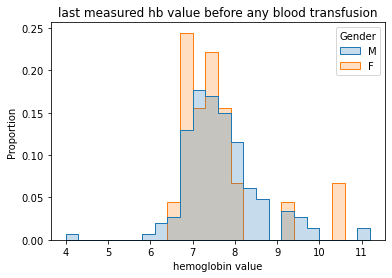

In [62]:
#q3 plot
sns.histplot(df_transfusions_merged,x = "pre_trans_hb",stat="probability",hue = "Gender",element="step",common_norm=False)
plt.title('Last measured hb value before any blood transfusion')
plt.xlabel("Hemoglobin value")
plt.ylabel('Proportion')
plt.show()

In [32]:
# q3 mean/std based on gender
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["pre_trans_hb"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["pre_trans_hb"]))
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["pre_trans_hb"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["pre_trans_hb"]))

7.607482993197274
0.9017811879470865
7.553333333333334
0.9708186694171517


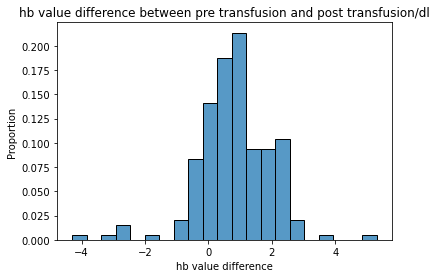

In [65]:
#plot of question 4
sns.histplot(df_transfusions_merged, x = "hb_diff",stat="probability") 
plt.title('Hb value difference between pre transfusion and post transfusion/dl')
plt.xlabel("Hb value difference")
plt.ylabel('Proportion')
plt.show()

In [34]:
print(np.mean(df_transfusions_merged["hb_diff"]))
print(np.std(df_transfusions_merged["hb_diff"]))

0.8104166666666665
1.1279571474080432


In [35]:
df_transfusions_merged= df_transfusions_merged.sort_values(by=['Gender'] ,ascending = False)

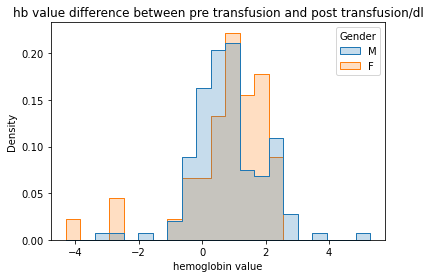

In [37]:
#plot for questions 5
## it seems to indicate that there are female patient that suffers from severer blood loss which require multiple blood transfusion
## there are 45 instances of female blood transfusion, and patient number holds the majority of the numbers of 25, this essentially
## makes the female density seems to have a high anoumaly because the hypothesis should be that female will have a positive increase
## in the diffrence between pre transfusion and post
sns.histplot(df_transfusions_merged,x = "hb_diff",stat="probability",hue = "Gender",element="step",common_norm=False)
plt.title('Hb value difference between pre transfusion and post transfusion/dl')
plt.xlabel("Hb value difference")
plt.ylabel('Proportion')
plt.show()

In [99]:
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["hb_diff"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["hb_diff"]))
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["hb_diff"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["hb_diff"]))

0.8204081632653059
1.0605439995112638
0.7777777777777778
1.3239484529893295


In [100]:
# plot for self investigated EDA 
# number of hb measure in the first 24 hours of ICU
# correaltion between hb difference in pre transfusion value



In [43]:
# time diffrence between pre transfusion and blood transfusion 
time = []

for row_index, row in df_transfusions_merged.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row["PATIENT_NUMBER"]] 
    temp_df_pretrans = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() > 0]
    pretrans = temp_df_pretrans.loc[temp_df_pretrans["RESULT_TIME"] == temp_df_pretrans["RESULT_TIME"].max()]["RESULT_TIME"]
    pretrans = round(float((row["BLOOD_START_TIME"] -pretrans).dt.total_seconds()/60),2)
    time.append(pretrans)
df_transfusions_merged["time"] = time

In [50]:
first_transfusion = df_transfusions_merged.groupby(["PATIENT_NUMBER"])[["BLOOD_START_TIME","VOLUME","Gender","time"]].agg("min")
first_transfusion = first_transfusion.sort_values(by=['Gender'] ,ascending = False)

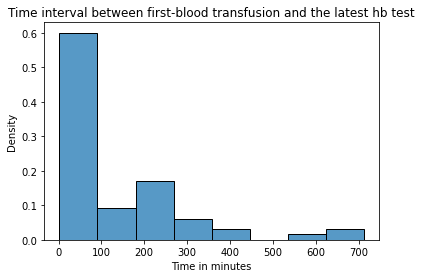

In [53]:
## time interval using gender 
sns.histplot(first_transfusion,x = "time",stat="probability")
plt.title('Time interval between first-blood transfusion and the latest hb test')
plt.xlabel("Time in minutes")
plt.ylabel('Density')
plt.show()

In [73]:
np.mean(first_transfusion["time"])

129.33846153846153

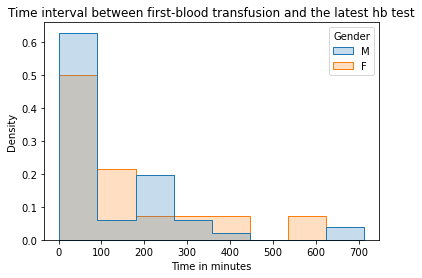

In [55]:
sns.histplot(first_transfusion,x = "time",stat="probability",hue = "Gender",element="step",common_norm=False)
plt.title('Time interval between first-blood transfusion and the latest hb test')
plt.xlabel("Time in minutes")
plt.ylabel('Density')
plt.show()

In [75]:
print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "M"]["time"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "M"]["time"]))
print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "F"]["time"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "F"]["time"]))

122.86274509803921
151.34754441452816
152.92857142857142
171.55360023940634


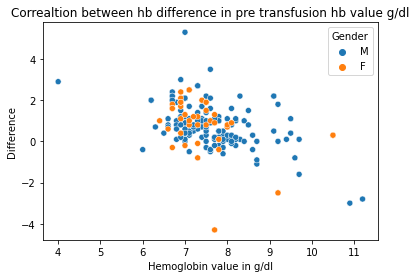

In [68]:
## correaltion between hb difference in pre transfusion hb value
sns.scatterplot(data = df_transfusions_merged, y = "hb_diff", x='pre_trans_hb',hue="Gender")
plt.title('Correaltion between hb difference in pre transfusion hb value g/dl')
plt.xlabel("Hemoglobin value in g/dl")
plt.ylabel('Difference')
plt.show()

In [69]:
## number of hb measure in the first 24 hours of ICU
## duplicate rows with same patient_num+admission num but different ICU_stay num
df_icu = df_icu_stays
df_icu = pd.merge(df_icu,df_patients[["PATIENT_NUMBER","Gender"]], on=["PATIENT_NUMBER"],how = "inner")


In [70]:
hb_measure = []

for row_index, row in df_icu.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row["PATIENT_NUMBER"]] 
    temp_df = temp_df.loc[temp_df["RESULT_TIME"] <= row["ICU_START_TIME"]+datetime.timedelta(days=1)]
    temp_df = temp_df.loc[temp_df["RESULT_TIME"] > row["ICU_START_TIME"]]
    hb_measure.append(len(temp_df))

df_icu["hb_measure"] = hb_measure

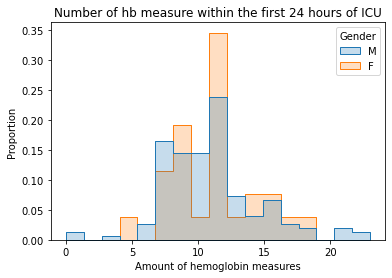

In [71]:
sns.histplot(df_icu,x = "hb_measure",stat="probability",hue = "Gender",element="step",common_norm=False)
plt.title('Number of hb measure within the first 24 hours of ICU')
plt.xlabel("Amount of hemoglobin measures")
plt.ylabel('Proportion')
plt.show()

In [72]:
print(np.mean(df_icu["hb_measure"]))
print(np.mean(df_icu.loc[df_icu["Gender"] == "M"]["hb_measure"]))
print(np.std(df_icu.loc[df_icu["Gender"] == "M"]["hb_measure"]))
print(np.mean(df_icu.loc[df_icu["Gender"] == "F"]["hb_measure"]))
print(np.std(df_icu.loc[df_icu["Gender"] == "F"]["hb_measure"]))

11.07909604519774
11.026490066225165
3.5527193574335163
11.384615384615385
3.0009860312509473
